<a href="https://colab.research.google.com/github/CatarinaRRF/IC_design_de_siRNA/blob/main/code/siRNA_Seeker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://raw.githubusercontent.com/CatarinaRRF/siRNA_Seeker/main/static/img/siRNAseeker_preto.png" >
<hr color ='66A80F' size="10">

###### <font color=1D2633><b>Automatizando o design de siRNA</B>

## <font color=0A0908><b> 01. Introdução</b>

Bem-vindo ao siRNA Seeker! Aqui você encontrará uma ferramenta projetada para facilitar a pesquisa e o desenvolvimento no campo da genética e biotecnologia, especificamente na busca por siRNA.

### <font color=66A80F> <b> O que o siRNA Seeker é?</b></font>

O algoritmo apresentado aqui foi desenvolvido para automatizar o processo de design de siRNA. OS siRNA, ou RNA de interferência pequeno, desempenha um papel crucial na regulação da expressão gênica por meio do silenciamento pós-transcricional de genes. Essa capacidade de manipular processos genéticos utilizando siRNA tem sido fundamental para o avanço de novas tecnologias e aplicações na pesquisa científica.

### <font color=66A80F><b>Como Utilizar este Notebook</b> </font>
O Google Colab utiliza células para organizar o código e as explicações. Existem dois tipos principais de células:

* <b>Células de Código:</b> Contêm comandos de programação que executam o algoritmo.
* <b>Células de Texto:</b> Servem para fornecer explicações e instruções sobre o que está acontecendo.
</br>
Para garantir que o algoritmo funcione corretamente, todas as células de código devem ser executadas na ordem em que aparecem. Isso porque algumas células dependem de comandos que foram executados anteriormente.

### <font color=66A80F><b> O que você precisa fazer? </b> </font>

> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

</br>
<hr>
⚠️ <b>Atenção!</b> Para evitar erros, <font color=red><b>execute todas as células na ordem em que aparecem no notebook</font></b>. Isso garante que todas as etapas sejam concluídas corretamente e que o algoritmo funcione sem problemas.

## <font color=0A0908><b> 02. Entrada de dados</b>

<font size=4><b>📤 Como Fazer Upload de um Arquivo no Google Colab</b></font>

Para que o algoritmo funcione corretamente, você precisará **fazer o upload de um arquivo no formato FASTA**.  

✅ **Requisitos do arquivo:**  
- O arquivo **deve estar no formato `.fasta`**.  
- O nome do arquivo **deve ser exatamente** `sequence.fasta`.  

📌 **Passos para fazer o upload:**  

1. **Localize o botão de upload** no notebook, localizado na aba direita do site. O icone é o seguinte:

<center>
    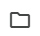
</center>

2. Clique no botão **“Escolher arquivo”**.  
3. Selecione ou arraste seu arquivo `sequence.fasta` do seu computador.  
4. Aguarde o carregamento ser concluído.  
5. **Não pule essa etapa!** O algoritmo precisa desse arquivo para funcionar corretamente.  

⚠️ **Importante:**  
Se o nome do arquivo for diferente de `sequence.fasta`, o código pode não reconhecer os dados e gerar erros. Certifique-se de que o nome está correto antes de fazer o upload.

##### <font color=66A80F><b> Preparando ambiente
<hr color ='66A80F' size="3">

Instalando bibliotecas necessárias  para o funcionamento do algoritimo.

> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.


In [1]:
pip install requests

In [2]:
pip install biopython

In [3]:
pip install seqfold

In [4]:
# @markdown **Rode esta célula para preparar o ambiente**
# Tratamento dos dados
import Bio
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq

# Mais
import requests
import time
import xml.etree.ElementTree as ET
import json

# Filtros
import re
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import gc_fraction
from seqfold import dg, fold, Struct
import pandas as pd

# Blast
from Bio.SeqRecord import SeqRecord
from Bio.Blast import NCBIWWW

# Barra de progresso
from tqdm import tqdm
import time

# Mensagem de Sucesso
print('as bibliotecas foram importadas com sucesso')

as bibliotecas foram importadas com sucesso


##### <font color=66A80F><b> Entrada de dados
<hr color ='66A80F' size="3">

<font size=2> Funções que determinam como o algoritimo ira ler o arquivo fasta e extrair a sequencia (`entrada_dados`) e identificando de qual gene se trata (`extract_gene_symbol_from_header`)

> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

In [5]:
def entrada_dados(tipo='fasta'):
  if tipo == 'fasta':
    # selecionar o arquivo FASTA
    nome_arquivo = "/content/sequence.fasta"

    try:
        # Le o arquivo FASTA e armazena as sequencias em uma lista
        sequencias = list(SeqIO.parse(nome_arquivo, 'fasta'))

        # Verifica se o arquivo nao está vazio
        if len(sequencias) > 0:
          # Define o nome do arquivo de saída
          nome_arquivo_saida = 'meugene.fasta'

          # Salva as sequencias no arquivo de saida
          SeqIO.write(sequencias, nome_arquivo_saida, 'fasta')
          print(f'O arquivo {nome_arquivo} foi salvo como {nome_arquivo_saida}.')

        else:
          print('O arquivo FASTA está vazio.')
    except Exception as e:
          print(f'Ocorreu um erro ao ler o arquivo FASTA: {str(e)}')
  else: print('pedir valdeir')

  return sequencias

In [7]:
def extract_gene_symbol_from_header(header):
    # Expressão regular para capturar siglas de genes entre parênteses.
    match = re.search(r'\(([^)]+)\)', header)
    if match:
        return match.group(1)
    return None

def meta_data(sequence, tamanho, autor, form_id):
  sequencias = list(SeqIO.parse(sequence, 'fasta'))
  # Gene Symbol
  header = sequencias[0].description
  gene_symbol = extract_gene_symbol_from_header(header)
  # RefSeq acenssion number
  refseq_numbers = sequencias[0].name
  # Original gene Size
  gene_size = len(sequencias[0].seq)
  # dic
  meta = {
          'Form_id': form_id, #enter data
          'gene_symbols': gene_symbol, #run funciton
          'refseq_numbers': refseq_numbers, #run function
          'autor':autor, #enter data
          'gene_size': gene_size, #run function
          'sirna_size':tamanho, #enter data
  }
  return meta

> <font size=2 color=66A80F><b> executando a função

In [9]:
sequencias = entrada_dados()
sequencias

O arquivo /content/sequence.fasta foi salvo como meugene.fasta.


[SeqRecord(seq=Seq('CTTTTTGGTGTAAATCTGGACTCTAATTCTGTAATATATCAAGGAATCTCGTAA...AAA'), id='NM_004502.4', name='NM_004502.4', description='NM_004502.4 Homo sapiens homeobox B7 (HOXB7), mRNA', dbxrefs=[])]

## <font color=0A0908><b> 03. Construção dos possiveis siRNA</b>

Em seguida devemos trasformar a sequencia em RNA (`trascrever`) realizada pela função [Bio.Seq.transcribe](https://biopython.org/docs/1.75/api/Bio.Seq.html#Bio.Seq.transcribe) da biblioteca Biopython. Essa função converte a sequência de DNA em RNA, substituindo as bases de timina (T) por uracila (U). Essa transformação é essencial para que possamos analisar corretamente as sequências pois, certos critérios de avaliação analisam a uracila.

Após a transcrição, o código procede com a identificação de todas as possíveis sequências de siRNA (`possiveis_siRNA`). O algoritmo então itera sobre a sequência de RNA transcrita, gerando substrings do comprimento especificado, para encontrar todas as possíveis sequências de siRNA que serão analisadas conforme os critérios estabelecidos.

Por exemplo, considere a seguinte sequência de RNA transcrita:
<font color=66A80F>
  <b>
    <center>
      <code>
      123456789</br>AUGGAGUUC
      </code>
    </center>
  </b>
</font>

E queremos gerar subsequências de tamanho 3 (simulando um siRNA de 3 nucleotídeos para simplificação).

A iteração sobre essa sequência de RNA produziria:
><font color=66A80F>
  <b>
  <font color=black> Sequência 1:</font></br>
    <center>
      <code>
      123</br>AUG
      </code>
    </center>
  <font color=black> Sequência 2:</font></br>
    <center>
      <code>
      234</br>UGG
      </code>
    </center>
  </b>
  <font color=black> ... </font></br></br>
  <font color=black><b> Sequência 7: </b></font></br>
    <center>
      <code>
      789</br>UCU
      </code>
    </center>
</font>

<hr>

> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.


##### <font color=66A80F><b> Trascrevendo em RNA
<hr color ='66A80F' size="3">

<font size=2>Para realizar a análise da sequência de DNA fornecida, utilizaremos a função <font color=66A80F>`transcrever()`</font>, onde, convertera a sequência de DNA em uma sequência de RNA.  
> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

In [10]:
def transcrever(sequencias):
    for sequencia in sequencias:
        name = sequencia.name
        print()
        print("*"*28, 'Informações', "*"*28)
        print(f'Nome: {sequencia.name}')
        print(f'Descrição: {sequencia.description}')
        print(f'Tamanho: {len(sequencia.seq)}')

     # Converte as letras T para U
        sequencia_convertida = Bio.Seq.transcribe(sequencia.seq)
        print()
        print("*"*28, 'Sequências', "*"*28)
        print(f'* Sequência de DNA:\n {sequencia.seq}')
        print(f'\n* RNA:\n {sequencia_convertida}')
        return sequencia_convertida, name


##### <font color=66A80F><b>Achando todas as possiveis sequencias de siRNA
<hr color ='66A80F' size="3">

<font size=2> Usando a função <b><font color=66A80F>`possiveis_siRNA()`</font></b> o algotimo busca na sequência de RNA por potenciais siRNA de tamanho especifico e as salva em uma lista separada.
> <b><font size=2 color=red> Clique no botão de play ▶ ao lado de todas as células e não pule nenhuma.

In [12]:
def possiveis_siRNA(dado, tamanho=21):
    # definindo variaveis
    possiveis_siRNA = []
    tuplas = []
    # iterando
    for index, _ in enumerate(dado):
        f = index + tamanho
        sequence_p = Seq(dado[index:f])  # convertendo para objeto Seq
        possiveis_siRNA.append(str(sequence_p))
        tuplas.append((str(sequence_p), f'{index}:{index+tamanho}'))

    siRNA = possiveis_siRNA[:-tamanho]

    return siRNA, tuplas

##### <font color=66A80F><b> Executando a Função </b>


> <font size=2>Adicione o tamanho da sequência do siRNA, sendo o padrão recomendado de 21 nucleotídeos. Não insira valores menores que 10, pois isso resultará em erro.

In [36]:
Tamanho = 21 # @param {type:"integer"} { run: "auto" }
Tamanho_1 = Tamanho-1

a = transcrever(sequencias)
name = a[1]
sequencia_convertida = a[0]
siRNA, siRNA_tuplas = possiveis_siRNA(sequencia_convertida, Tamanho)
quantidade = len(siRNA_tuplas[-Tamanho_1:][0][0])
print(f'Foram selecionados {quantidade} possiveis sirnas com o tamanho de {Tamanho}pb')

Foram selecionados 20 possiveis sirnas com o tamanho de 21pb


## <font color=0A0908><b> 04. Classificação dos siRNA quando sua funcionalidade</b>

Após a seleção das sequências possíveis, o algoritmo inicia sua análise aplicando os critérios de otimização estabelecidos por três autores: Reynolds et al. (2004), Ui-Tei et al. (2004) e Amarzguioui et al. O usuário pode optar pelo autor cujas diretrizes prefere seguir na determinação da funcionalidade das sequências. Alguns critérios são comuns entre todos os autores, como: energia livre, conteúdo de GC e temperatura de melting.

Além disso, uma pontuação é atribuída a cada parâmetro de acordo com sua importância. Essa pontuação é representada como "score", um parâmetro criado especificamente para este algoritmo que determina a conformidade da sequência analisada. A forma como a pontuação é calculada é demonstrada pela tabela abaixo:
</br>

| Rank | Critério                                   | Pontuação |
| ---- | ------------------------------------------ | --------- |
| 1    | Ausência de repetições invertidas (hairpin) | -         |
| 2    | Estabilidade interna baixa                 | -2 a 10   |
| 3    | Baixo teor de GC                           | 0 ou 4    |
| 4    | Posições específicas                       | -4 a 6    |
| **Total** | **Pontuação Final**                       | **0 a 20**  |

</br>

Os siRNAs candidatos são avaliados de acordo com esses critérios para determinar sua viabilidade. Para o primeiro critério, os siRNAs que não atendem a esse requisito (ausência de repetições invertidas) são descartados. Para os demais critérios, é atribuída uma pontuação: 10 pontos para o critério de baixa estabilidade interna, 4 pontos para o critério de baixo teor de GC e 1 ponto para cada posição específica.

É importante destacar que, no caso das posições específicas, cada posição que corresponde a um nucleotídeo ideal recebe 1 ponto, enquanto a não conformidade com essa posição resulta em 0 pontos. Nas posições onde o nucleotídeo precisa ser específico, é deduzido 1 ponto caso não esteja em conformidade.

A pontuação final será transformada em percentual. Somente as sequências com mais de 80% de conformidade (pontuação superior a 16) serão levadas para as próximas fases do processo.

##### <font color=66A80F><b>  Reynolds
<hr color ='66A80F' size="3">

Reynolds et al. (2004) realizaram uma análise detalhada de 180 siRNAs e os seguintes critérios específicos para otimizar a eficiência desses siRNAs foram determinados:
Aqui está a tabela com os parâmetros de **Reynolds et al. (2004)** organizados de forma clara:

**Características da sequência (Fita Senso)**

| Posição | Nucleotídeo Recomendado |
| ------- | ----------------------- |
| 3       | A                       |
| 10      | U                       |
| 13      | Exceto G                 |
| 19      | Exceto G e C             |
| 19      | A                       |

**Características que influenciam a termodinâmica**

| Critério                                  | Descrição                                                    |
| ----------------------------------------- | ------------------------------------------------------------ |
| Ausência de repetições invertidas (hairpin) | Sequências com alta Tm favorecem estruturas secundárias (hairpin). Tm < 20ºC |
| Estabilidade interna baixa (3+ A/U)       | A extremidade 3' da fita senso (posições 15-19) deve ter A/U para aumentar a eficácia do siRNA |
| Baixo conteúdo de GC                      | Conteúdo de GC entre 30% e 52%; |

In [15]:
def reynolds (sequence):
  score = 0
  falha = []
  # Instabilidade na posição 15 - 19
  #----------------------------------#
  check_estabilidade = 0
  for letra in sequence[14:19]:
     if letra == "A" or letra == "G":
        check_estabilidade += 1
  if check_estabilidade >= 1:
     score += 1
  else:
     falha.append(str("estabilidade interna"))
  # Posição 13
  #----------------------------------#
  if sequence[12] != "G":
     score += 1
  else:
     falha.append(str("posição 13"))
  # Posição 19
  #----------------------------------#
  if sequence [18] != "G" and sequence [18] != "C":
     score += 1
  else:
     falha.append(str("posição 19"))
  if sequence [18] == "A":
     score += 1
  else:
     falha.append(str("posição 19!= A"))
  # Posição 10
  #----------------------------------#
  if sequence [9] == "U":
     score += 1
  else:
     falha.append(str("posição 10"))

  # Posição 3
  #----------------------------------#
  if sequence [2] == "A":
     score += 1
  else:
     falha.append(str("posição 3"))

  return score, falha

##### <font color=66A80F><b>  Ui-Tei
<hr color ='66A80F' size="3">



Ui-Tei et al. (2004) realizaram uma análise de siRNA em diferentes tipos celulares e estabeleceram critérios específicos para otimizar a eficácia desses siRNA. Eles focaram principalmente em características da sequência e estabilidade termodinâmica.

**Características da sequência**

| Posição | Nucleotídeo Recomendado | Descrição |
| ------- | ----------------------- | --------- |
| 5' Extremidade da fita antisenso | A/U | A extremidade 5' da fita antisenso deve conter nucleotídeos A/U, </br> relacionada à formação do RISC e ao reconhecimento do RNAm. |
| 5' Extremidade da fita senso | G/C | A extremidade 5' da fita senso deve conter nucleotídeos G/C. |
| 5' Extremidade da fita antisenso | Pelo menos 5 A/U | A extremidade 5' da fita antisenso deve ter pelo menos cinco </br> nucleotídeos A/U consecutivos de um total de sete. |
| Sequência G/C consecutiva | Nenhuma sequência de mais de 9 G/C consecutivos | A sequência não deve ter mais de nove nucleotídeos G/C seguidos. |

**Considerações de estabilidade e eficiência**

| Critério                               | Descrição                                                                                                                                                  |
| -------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Estabilidade interna baixa (ΔGº)      | SiRNA mais eficazes apresentaram ΔGº entre -3,6 a -7,2 kcal/mol. </br> siRNA ineficazes tiveram ΔGº maior que -9,8 kcal/mol.                                 |
| Relação com eficiência                 | A estabilidade interna baixa está correlacionada com a maior eficiência funcional do siRNA. </br>SiRNA com ΔGº mais baixo demonstraram maior eficiência no silenciamento. |

</br>

In [16]:
def Ui_Tei (sequence, extremidade=7):
  # Variaveis
  #----------------------------------#
  score = 0
  falha = []
  antisenso = Seq(sequence).complement_rna()

  #Senso
  #----------------------------------#
  check_senso = 0

  for letra in sequence[:extremidade]:
      if letra == "G" or letra == "C":
         check_senso += 1
  if check_senso == 5:
     score += 1
  else:
     falha.append(str("Extremidade senso"))

  #Antisenso
  #----------------------------------#
  check_antisenso = 0

  for letra in antisenso[-extremidade:]:
      if letra == "A" or letra == "U":
         check_antisenso += 1
  if check_antisenso == extremidade:
     score += 1
  else:
     falha.append(str("Extremidade antisenso"))

  # Presença de no minimo 5 A/U nas posições [:7]
  #----------------------------------#
  check_min_5 = 0

  for letra in antisenso[-7:]:
      if letra == "A" or letra == "U":
         check_min_5 += 1
  if check_min_5 >= 5:
     score += 1
  else:
     falha.append(str("posições [:7]"))

  # Mais de 9 repetições
  #----------------------------------#
  segment_size = 9
  check = True

  for index in range(len(sequence) - segment_size + 1):
        segmento = sequence[index:index + segment_size]
        count = 0
        for letra in segmento:
            if letra == 'C' or letra == 'G':
                count += 1
        if count >= segment_size:
            check = False

  if check == True:
    score += 1
  else:
    falha.append(str("Repetição de mais de 9 C/G seguidos"))

  return score, falha

##### <font color=66A80F><b>  Amarzguioui
<hr color ='66A80F' size="3">

Amarzguioui et al. (2005) realizaram uma análise de 46 moléculas de siRNA, complementares a quatro genes, com o objetivo de avaliar a eficiência de knockdown. Após testes, 21 (46%) dos siRNAs atingiram um critério de eficiência de 70%. A partir desse estudo, os autores propuseram critérios específicos que se mostraram eficazes para o design de siRNAs eficientes.

**Características da sequência**

| Posição | Nucleotídeo Recomendado         | Descrição                                                                                                  |
| ------- | ------------------------------- | -------------------------------------------------------------------------------------------------------- |
| Posição 1 | Não U                           | A posição 1 não deve conter U para evitar redução na eficiência do siRNA.                                 |
| Posição 1 | G ou C                          | A presença de G ou C melhora a formação do duplex, sendo nucleotídeos com ligação forte.                  |
| Posição 6 | A                               | A presença de A é importante para a eficiência do siRNA.                                                  |
| Posição 19 | Não G                           | A presença de G prejudica a formação do duplex, devendo ser evitada.                                      |
| Posição 19 | A ou U                          | A ou U são preferidos nesta posição, pois suas interações mais fracas contribuem para a eficiência.       |

**Assimetria das extremidades do duplex**

| Critério                          | Descrição                                                                                                  |
| ---------------------------------- | -------------------------------------------------------------------------------------------------------- |
| Assimetria das extremidades       | A diferença entre A/U nos três pares de bases terminais em qualquer extremidade do duplex deve ser grande. |

</br>

In [17]:
def Amarzguioui(sequence):
  score = 0
  falha = []
  check_assimetria_5 = 0
  check_assimetria_3 = 0
  antisenso = Seq(sequence).complement_rna()

  # Posição 1
  #----------------------------------#
  if sequence [0] != "U" and sequence [0] != "A":
     score += 1
  else:
     falha.append(str("posição 1"))
  # Posição 6
  #----------------------------------#
  if sequence [5] == "A":
     score += 1
  else:
     falha.append(str("posição 6"))
  # Posição 19
  #----------------------------------#
  if sequence [18] != "G" and sequence [18] != "C":
     score += 1
  else:
     falha.append(str("posição 19"))
  # Assimetria
  #----------------------------------#
  for letra in sequence[:3]:
      if letra == "A" or letra == "U": # baixo
         check_assimetria_5 += 1
  for letra in antisenso[-3:]:
      if letra == "A" or letra == "U": # alto
         check_assimetria_3 += 1
  if check_assimetria_3 > check_assimetria_5:
     score += 1
  else:
     falha.append(str("assimetria"))

  return score, falha

##### <font color=66A80F><b>  Função para a funcionalidade do siRNA
<hr color ='66A80F' size="3">

In [18]:
def siRNA_score (sequence,
                 autor=['reynolds', 'ui-tei', 'amarzguioui'],
                 tm=True, tmmax = 21.5):

  # Definindo variaveis
  #--------------------------------------------------------------#
  score = 0
  falha = []

  # Conteudo Baixo GC
  #--------------------------------------------------------------#
  conteudo_gc = round(gc_fraction(sequence)*100, 2)
  if 30 <= conteudo_gc <= 52:
     score += 1
  else:
     falha.append(str("Conteudo CG"))

  # tempmelt
  #--------------------------------------------------------------#
  if tm == True:
     tm_score = round(mt.Tm_GC(sequence[1:8]), 2)
     if 0 < tm_score <= tmmax:
        score += 1
     else:
        falha.append(str("tm"))

  # G°
  #--------------------------------------------------------------#
  energia_livre = dg(sequence)
  if -13 < energia_livre < -7:
     score += 2
  else:
     falha.append(str("Energia livre"))

  # Autores
  # Score reynolds total = 6
  #--------------------------------------------------------------#
  if autor == 'reynolds':
    r = reynolds(sequence)
    score += r[0]
    falha.extend(r[1] if isinstance(r[1], list) else [r[1]])

  # Score ui-tei total = 4
  #--------------------------------------------------------------#
  if autor == 'ui-tei':
    u = Ui_Tei(sequence)
    score += u[0]
    falha.extend(u[1] if isinstance(u[1], list) else [u[1]])

  # Score amarzguioui total = 4
  #--------------------------------------------------------------#
  if autor == 'amarzguioui':
    a = Amarzguioui(sequence)
    score += a[0]
    falha.extend(a[1] if isinstance(a[1], list) else [a[1]])
  #--------------------------------------------------------------#

  return score, falha, conteudo_gc, energia_livre, tm_score

##### <font color=66A80F><b>Selecionando siRNA funcionais
<hr color ='66A80F' size="3"></b>

In [37]:
def filtro_siRNA(sequences, identidade=0.6,
                 autor=['reynolds', 'ui-tei', 'amarzguioui'],
                 tm=True, tmmax=21.5):

    # Definindo Variaveis
    # --------------------------------------------------------------#
    siRNA_verificados = []
    score = []
    falha = []
    conteudo_gc = []
    energia_livre = []
    TM_score = []

    total_reynolds = round(10 * identidade)
    total_uitei_ama = round(8 * identidade)

    # Iterador
    # --------------------------------------------------------------#
    for sequence in sequences:
        # Veficando a qualidade
        # ----------------------------------#
        resultado = siRNA_score(sequence=sequence, autor=autor,
                                tm=tm, tmmax=tmmax)

        # Exclui RNAs indesejadas
        # ----------------------------------#
        incluir_siRNA = True

        if autor == "reynolds":
            if resultado[0] <= total_reynolds or resultado[4] > tmmax or resultado[4] < -8:
                incluir_siRNA = False

        if autor == 'ui-tei' or autor == 'amarzguioui':
            if resultado[0] <= total_uitei_ama or resultado[4] > tmmax or resultado[4] < -8:
                incluir_siRNA = False

        if incluir_siRNA:
            siRNA_verificados.append(sequence)
            score.append(resultado[0])
            falha.append(resultado[1])
            conteudo_gc.append(resultado[2])
            energia_livre.append(resultado[3])
            TM_score.append(resultado[4])

        # Pandas
        dataset = pd.DataFrame({
                            "Sequência 5' ➔ 3'": siRNA_verificados,
                            "Pontuação": score,
                            "Temperatura de Melting": TM_score,
                            "Conteudo CG": conteudo_gc,
                            "energia_livre": energia_livre,
                            "Falhas": falha
                            })
        dataset = dataset.sort_values(by=["Pontuação"],
                                  ascending=False, ignore_index=True)

    return dataset, siRNA_verificados


In [38]:
def filtro_siRNA(sequences, conformidade=0.6,
                    autor=['reynolds', 'ui-tei', 'amarzguioui'],
                    tm=True, tmmax=21.5):

        # Definindo Variaveis
        # --------------------------------------------------------------#
        siRNA_verificados = []
        posicao = []
        score = []
        falha = []
        conteudo_gc = []
        energia_livre = []
        TM_score = []

        total_reynolds = round(10 * conformidade)
        total_uitei_ama = round(8 * conformidade)

        # Iterador
        # --------------------------------------------------------------#
        for index, sequence in enumerate(sequences):
            # Veficando a qualidade
            # ----------------------------------#
            resultado = siRNA_score(sequence=sequence, autor=autor,
                                    tm=tm, tmmax=tmmax)

            # Exclui RNAs indesejadas
            # ----------------------------------#
            incluir_siRNA = True

            if autor == "reynolds":
                if resultado[0] <= total_reynolds or resultado[4] > tmmax:
                    incluir_siRNA = False

            if autor == 'ui-tei' or autor == 'amarzguioui':
                if resultado[0] <= total_uitei_ama or resultado[4] > tmmax:
                    incluir_siRNA = False

            if incluir_siRNA:
                siRNA_verificados.append(sequence)
                posicao.append(index)
                score.append(resultado[0])
                falha.append(resultado[1])
                conteudo_gc.append(resultado[2])
                energia_livre.append(resultado[3])
                TM_score.append(resultado[4])

        # Organizando os resultados por pontuação
        resultados = list(zip(siRNA_verificados, score, TM_score, conteudo_gc, energia_livre, falha))
        resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)
        siRNA_verificados = [resultado[0] for resultado in resultados_ordenados]

        # Preparando dados para JSON
        dados_json = [
            {
                "Sequencia'": resultado[0],
                "Pontuacao": resultado[1],
                "TM": resultado[2],
                "CG": resultado[3],
                "AG": resultado[4],
                "Falhas": resultado[5]
            }
            for resultado in resultados_ordenados
        ]

        # Salvando em um arquivo JSON
        with open('resultados_siRNA.json', 'w') as arquivo_json:
            json.dump(dados_json, arquivo_json, indent=4)

        return dados_json, siRNA_verificados

##### <font color=66A80F><b>Resultado
<hr color ='66A80F' size="3"></b>

In [43]:
# @markdown ---
# @markdown ### **Insira os valores para cada parâmetros de funcionalidade**
identidades = 0.6 # @param {type:"number"}
autores = 'reynolds' # @param ["reynolds", "ui-tei", "amarzguioui"]
temperatura_de_melting_maxima = 21.5 # @param {type:"number"}

df, siRNA_verificados = filtro_siRNA(siRNA, conformidade = identidades,
                      autor=autores,
                      tm=True,
                      tmmax = temperatura_de_melting_maxima)

df = pd.json_normalize(df)
df

,Sequencia',Pontuacao,TM,CG,AG,Falhas
0,AAACGUCCCUGCCUACAAAUC,7,-2.38,47.62,2.4,"[tm, Energia livre]"
1,UCAUCCGGCCAAAUUAUGAGU,7,3.47,42.86,-0.3,"[Energia livre, posição 10]"
2,CGAGUUCCUUCAACAUGCACU,7,-2.38,47.62,1.5,"[tm, Energia livre]"
3,CCGGGGUGUGUCCCGGCGACU,7,9.33,76.19,-8.8,"[Conteudo CG, posição 10, posição 3]"
4,GUCCCGGCGACUCCGCCAAGG,7,9.33,76.19,-9.1,"[Conteudo CG, posição 10, posição 3]"
5,CCAAGGCGGCGGGCGCCAAGG,7,3.47,80.95,-8.5,"[Conteudo CG, posição 13, posição 10]"
6,CUGACGCGGCGGCGGCGCAUC,7,3.47,80.95,-8.3,"[Conteudo CG, posição 10, posição 3]"
7,UCAGGAAACUCAAAUCGAAUA,7,-8.24,33.33,1.8,"[tm, Energia livre]"
8,UUAAUGCUGUCUUUGUGGACU,7,-14.10,38.10,-0.2,"[tm, Energia livre]"
9,GGGGCCUUAGGGAGCCCCAAA,7,3.47,66.67,-10.5,"[Conteudo CG, posição 10, posição 3]"
